In [ ]:
pip install deepxde

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 13.4 MB/s eta 0:00:00


In [ ]:
import deepxde as dde
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

tf.keras.mixed_precision.set_global_policy('float32') # this just makes the gpu do stuff
dde.config.set_default_float("float32")

No backend selected.
Finding available backend...
Found tensorflow
Using backend: tensorflow
Other supported backends: tensorflow.compat.v1, pytorch, jax, paddle.
paddle supports more examples now and is recommended.


Setting the default backend to "tensorflow". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


Enable just-in-time compilation with XLA.



Set the default float type to float32


In [ ]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Compiling model...
'compile' took 0.013161 s

Training model...

Step      Train loss                                                                                    Test loss                                                                                     Test metric
0         [2.82e-03, 4.92e-03, 1.97e-02, 4.70e-01, 9.24e-01, 6.79e-02, 5.25e-01, 1.17e+00, 2.48e-01]    [2.82e-03, 4.92e-03, 1.97e-02, 4.70e-01, 9.24e-01, 6.79e-02, 5.25e-01, 1.17e+00, 2.48e-01]    []  
1000      [8.76e-03, 6.13e-03, 9.06e-03, 1.05e-02, 1.01e-02, 5.81e-03, 7.54e-03, 8.56e-03, 6.98e-03]    [8.76e-03, 6.13e-03, 9.06e-03, 1.05e-02, 1.01e-02, 5.81e-03, 7.54e-03, 8.56e-03, 6.98e-03]    []  
2000      [2.45e-03, 1.30e-03, 1.41e-03, 9.72e-04, 7.20e-04, 3.45e-04, 6.98e-04, 5.57e-04, 3.65e-04]    [2.45e-03, 1.30e-03, 1.41e-03, 9.72e-04, 7.20e-04, 3.45e-04, 6.98e-04, 5.57e-04, 3.65e-04]    []  
3000      [5.97e-03, 6.49e-03, 5.91e-04, 8.34e-03, 7.34e-03, 1.50e-03, 1.19e-02, 1.07e-02, 1.29e-03]    [5.97e-03, 6

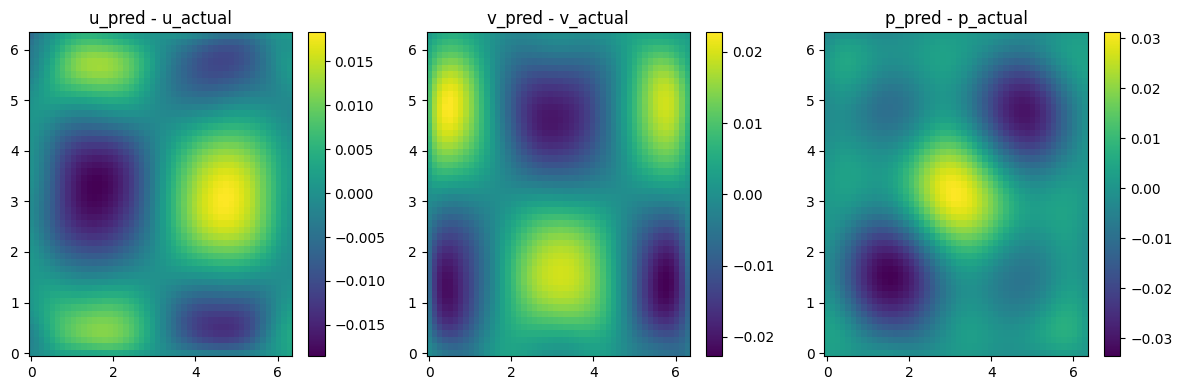

In [ ]:
nu = dde.backend.tf.constant(0.01, dtype="float32")
rho = dde.backend.tf.constant(1.0, dtype="float32")

d = 2 * np.pi
t = 1.0

# analytic solutions (Taylor-Green)
def taylor_green_u(x, y, t):
  return np.sin(x) * np.cos(y) * np.exp(-2 * nu * t)

def taylor_green_v(x, y, t):
  return -np.cos(x) * np.sin(y) * np.exp(-2 * nu * t)

def taylor_green_p(x, y, t):
  return 0.25 * np.exp(-4 * nu * t) * (np.cos(2 * x) + np.cos(2 * y))

def usol(x):
  return (tf.sin(x[:, 0:1]) * tf.cos(x[:, 1:2]) * tf.exp(-2 * nu * x[:, 2:3]))

def vsol(x):
  return (-tf.cos(x[:, 0:1]) * tf.sin(x[:, 1:2]) * tf.exp(-2 * nu * x[:, 2:3]))

def psol(x):
  return (0.25 * (tf.cos(2 * x[:, 0:1]) + tf.cos(2 * x[:, 1:2])) * tf.exp(-4 * nu * x[:, 2:3]))

# data stuff
geo = dde.geometry.Rectangle(xmin=[0.0, 0.0], xmax=[d, d])
time_dimension = dde.geometry.TimeDomain(0.0, t)
domain = dde.geometry.GeometryXTime(geo, time_dimension)

def naviar_stokes(x, y):
  u, v, p = y[:, 0:1], y[:, 1:2], y[:, 2:3]

  # a bunch of derivatives ig
  u_x = dde.grad.jacobian(y, x, i=0, j=0)
  u_y = dde.grad.jacobian(y, x, i=0, j=1)
  u_t = dde.grad.jacobian(y, x, i=0, j=2)
  u_xx = dde.grad.hessian(y, x, i=0, j=0)
  u_yy = dde.grad.hessian(y, x, i=0, j=1)
  v_x = dde.grad.jacobian(y, x, i=1, j=0)
  v_y = dde.grad.jacobian(y, x, i=1, j=1)
  v_t = dde.grad.jacobian(y, x, i=1, j=2)
  v_xx = dde.grad.hessian(y, x, i=1, j=0)
  v_yy = dde.grad.hessian(y, x, i=1, j=1)
  p_x = dde.grad.jacobian(y, x, i=2, j=0)
  p_y = dde.grad.jacobian(y, x, i=2, j=1)
  # ew

  return [(u * u_x + v * u_y + p_x - nu * (u_xx + u_yy) + u_t), (u * v_x + v * v_y + p_y - nu * (v_xx + v_yy) + v_t), (u_x + v_y)]

def boundary(x, stupid):
  return stupid

def initial(x, stupid):
  return stupid

# boundary conditions
bu = dde.DirichletBC(domain, usol, boundary, component=0)
bv = dde.DirichletBC(domain, vsol, boundary, component=1)
bp = dde.DirichletBC(domain, psol, boundary, component=2)

# initial conditions
iu = dde.IC(domain, usol, initial, component=0)
iv = dde.IC(domain, vsol, initial, component=1)
ip = dde.IC(domain, psol, initial, component=2)

data = dde.data.TimePDE(domain, naviar_stokes, [bu, bv, bp, iu, iv, ip], num_domain=10000, num_boundary=500, num_initial=500, train_distribution="Hammersley")

# neural network
ss = [3] + [67] * 4 + [3] # given (x, y, z) you get (u, v, p)
act = "tanh" # a lot of papers use tanh so ig its standard?? change later maybe
initial = "Glorot uniform" # xaviar initialize but its called glorot for some reason

neuralnetwork = dde.maps.FNN(ss, act, initial)
model = dde.Model(data, neuralnetwork)

# training
# no adaptive loss function
model.compile("adam", lr=1e-3)
losshist, trainstate = model.train(epochs=10000)
model.compile("L-BFGS-B")
losshist, trainstate = model.train()

n = 50
x, y = np.linspace(0, d, n), np.linspace(0, d, n)
X, Y = np.meshgrid(x, y)
tt = t * np.ones_like(X)
xt = np.vstack([X.ravel(), Y.ravel(), tt.ravel()]).T

# predictions
y_pred = model.predict(xt)
u_pred = y_pred[:, 0].reshape(n, n)
v_pred = y_pred[:, 1].reshape(n, n)
p_pred = y_pred[:, 2].reshape(n, n)

# analytical solutions
u_actual = taylor_green_u(X, Y, tt)
v_actual = taylor_green_v(X, Y, tt)
p_actual = taylor_green_p(X, Y, tt)

eu = dde.metrics.l2_relative_error(u_actual.flatten()[:, None], y_pred[:, 0:1])
ev = dde.metrics.l2_relative_error(v_actual.flatten()[:, None], y_pred[:, 1:2])
ep = dde.metrics.l2_relative_error(p_actual.flatten()[:, None], y_pred[:, 2:3])

loss_train = np.sum(losshist.loss_train, axis=1)
steps = np.array(losshist.steps)
np.savez("baseline_results.npz", x=X, y=Y, u_pred=u_pred, v_pred=v_pred, p_pred=p_pred, loss=loss_train, steps=steps, eu=eu, ev=ev, ep=ep)

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title("u_pred - u_actual")
plt.pcolormesh(X, Y, u_pred - u_actual, shading="auto")
plt.colorbar()
plt.subplot(1, 3, 2)
plt.title("v_pred - v_actual")
plt.pcolormesh(X, Y, v_pred - v_actual, shading="auto")
plt.colorbar()
plt.subplot(1, 3, 3)
plt.title("p_pred - p_actual")
plt.pcolormesh(X, Y, p_pred - p_actual, shading="auto")
plt.colorbar()
plt.tight_layout()
plt.show()

In [ ]:
#adaptive PINN
import deepxde as dde
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

nu = dde.backend.tf.constant(0.01, dtype="float32")
rho = dde.backend.tf.constant(1.0, dtype="float32")

d = 2 * np.pi
t = 1.0

# analytic solutions (Taylor-Green)
def taylor_green_u(x, y, t):
  return np.sin(x) * np.cos(y) * np.exp(-2 * nu * t)

def taylor_green_v(x, y, t):
  return -np.cos(x) * np.sin(y) * np.exp(-2 * nu * t)

def taylor_green_p(x, y, t):
  return 0.25 * np.exp(-4 * nu * t) * (np.cos(2 * x) + np.cos(2 * y))

def usol(x):
  return (tf.sin(x[:, 0:1]) * tf.cos(x[:, 1:2]) * tf.exp(-2 * nu * x[:, 2:3]))

def vsol(x):
  return (-tf.cos(x[:, 0:1]) * tf.sin(x[:, 1:2]) * tf.exp(-2 * nu * x[:, 2:3]))

def psol(x):
  return (0.25 * (tf.cos(2 * x[:, 0:1]) + tf.cos(2 * x[:, 1:2])) * tf.exp(-4 * nu * x[:, 2:3]))

class LossWeightLayer(tf.keras.layers.Layer):
  def __init__(self, init_log=0.0, **kwargs):
    super().__init__(**kwargs)
    self.k0 = tf.Variable(init_log, dtype=tf.float32, trainable=True, name="k0")
    self.k1 = tf.Variable(init_log, dtype=tf.float32, trainable=True, name="k1")
    self.k2 = tf.Variable(init_log, dtype=tf.float32, trainable=True, name="k2")
    self.hft = tf.Variable(1.0, dtype=tf.float32, trainable=False, name="hft")

  def call(self, x):
    return x

  def get_weights_pos(self):
    return tf.nn.softplus(self.k0), tf.nn.softplus(self.k1), tf.nn.softplus(self.k2) * self.hft

class HighFrequencyUpdate(dde.callbacks.Callback):
  def __init__(self, domain, net, layer, Ncoll=1024, beta=2.0, freq_threshold_fraction=0.25, update_every=50):
    super().__init__()
    self.domain = domain
    self.net = net
    self.layer = layer
    self.Ncoll = Ncoll
    self.beta = beta
    self.freq_threshold_fraction = freq_threshold_fraction
    self.update_every = update_every

    x_min, x_max = domain.geometry.xmin, domain.geometry.xmax
    t_min, t_max = domain.timedomain.t0, domain.timedomain.t1

    n_segments = 16
    pts_per_seg = int(self.Ncoll / n_segments)
    segments = []

    for _ in range(n_segments):
      r1 = np.random.rand(3)
      p1 = np.array([r1[0]*(x_max[0]-x_min[0])+x_min[0], r1[1]*(x_max[1]-x_min[1])+x_min[1], r1[2]*(t_max-t_min)+t_min])

      r2 = np.random.rand(3)
      p2 = np.array([r2[0]*(x_max[0]-x_min[0])+x_min[0], r2[1]*(x_max[1]-x_min[1])+x_min[1], r2[2]*(t_max-t_min)+t_min])

      t_steps = np.linspace(0, 1, pts_per_seg)[:, None]
      seg = p1 + t_steps * (p2 - p1)
      segments.append(seg)

    self.probe = np.vstack(segments).astype(np.float32)


  def on_epoch_end(self):
    epoch = self.model.train_state.epoch
    if epoch % self.update_every != 0:
      return

    original = float(self.layer.hft.numpy())
    self.layer.hft.assign(1.0)
    pts = tf.convert_to_tensor(self.probe, dtype=tf.float32)

    with tf.GradientTape(persistent=True) as tape2:
      tape2.watch(pts)
      with tf.GradientTape(persistent=True) as tape1:
        tape1.watch(pts)
        y = self.net(pts)
        u, v, p = y[:, 0:1], y[:, 1:2], y[:, 2:3]
      u_grads, v_grads, p_grads = tape1.gradient(u, pts), tape1.gradient(v, pts), tape1.gradient(p, pts)
      u_x, u_y, u_t = u_grads[:, 0:1], u_grads[:, 1:2], u_grads[:, 2:3]
      v_x, v_y, v_t = v_grads[:, 0:1], v_grads[:, 1:2], v_grads[:, 2:3]
      p_x, p_y = p_grads[:, 0:1], p_grads[:, 1:2]

    u_xx, u_yy = tape2.gradient(u_x, pts)[:, 0:1], tape2.gradient(u_y, pts)[:, 1:2]
    v_xx, v_yy = tape2.gradient(v_x, pts)[:, 0:1], tape2.gradient(v_y, pts)[:, 1:2]

    res_u = (u * u_x + v * u_y + p_x - nu * (u_xx + u_yy) + u_t)
    res_v = (u * v_x + v * v_y + p_y - nu * (v_xx + v_yy) + v_t)
    res_p = (u_x + v_y)
    residual_vals = np.sqrt(res_u.numpy().flatten()**2 + res_v.numpy().flatten()**2 + res_p.numpy().flatten()**2)

    self.layer.hft.assign(original)
    freqs = np.fft.fft(residual_vals)
    ps = np.abs(freqs) ** 2
    cutoff = int(len(ps) * self.freq_threshold_fraction)
    ratio = np.sum(ps[cutoff:]) / (np.sum(ps) + 1e-12)

    spec = float(np.clip(1.0 + self.beta * float(ratio), 1.0, 10.0))
    self.layer.hft.assign(spec)

def build_fnn(layer_sizes, activation="tanh", initializer="glorot_uniform"):
  model = tf.keras.Sequential()
  for size in layer_sizes[1:-1]:
    model.add(layers.Dense(size, activation=activation, kernel_initializer=initializer))
  model.add(layers.Dense(layer_sizes[-1], activation=None, kernel_initializer=initializer))
  lw = LossWeightLayer(init_log=0.0)
  model.add(lw)
  model.regularizer = None
  return model, lw

# data stuff
geo = dde.geometry.Rectangle(xmin=[0.0, 0.0], xmax=[d, d])
time_dimension = dde.geometry.TimeDomain(0.0, t)
domain = dde.geometry.GeometryXTime(geo, time_dimension)

def naviar_stokes(x, y):
  u, v, p = y[:, 0:1], y[:, 1:2], y[:, 2:3]

  # a bunch of derivatives ig
  u_x = dde.grad.jacobian(y, x, i=0, j=0)
  u_y = dde.grad.jacobian(y, x, i=0, j=1)
  u_t = dde.grad.jacobian(y, x, i=0, j=2)
  u_xx = dde.grad.hessian(y, x, i=0, j=0)
  u_yy = dde.grad.hessian(y, x, i=0, j=1)
  v_x = dde.grad.jacobian(y, x, i=1, j=0)
  v_y = dde.grad.jacobian(y, x, i=1, j=1)
  v_t = dde.grad.jacobian(y, x, i=1, j=2)
  v_xx = dde.grad.hessian(y, x, i=1, j=0)
  v_yy = dde.grad.hessian(y, x, i=1, j=1)
  p_x = dde.grad.jacobian(y, x, i=2, j=0)
  p_y = dde.grad.jacobian(y, x, i=2, j=1)
  # ew

  _, _, kf = loss_weight_layer.get_weights_pos()
  sqrt_kf = tf.sqrt(tf.maximum(kf, 1e-12))
  return [sqrt_kf * (u * u_x + v * u_y + p_x - nu * (u_xx + u_yy) + u_t), sqrt_kf * (u * v_x + v * v_y + p_y - nu * (v_xx + v_yy) + v_t), sqrt_kf * (u_x + v_y)]

def boundary(x, stupid):
  return stupid

def initial(x, stupid):
  return stupid

# boundary conditions
bu = dde.DirichletBC(domain, usol, boundary, component=0)
bv = dde.DirichletBC(domain, vsol, boundary, component=1)
bp = dde.DirichletBC(domain, psol, boundary, component=2)

# initial conditions
iu = dde.IC(domain, usol, initial, component=0)
iv = dde.IC(domain, vsol, initial, component=1)
ip = dde.IC(domain, psol, initial, component=2)

data = dde.data.TimePDE(domain, naviar_stokes, [bu, bv, bp, iu, iv, ip], num_domain=10000, num_boundary=500, num_initial=500, train_distribution="Hammersley") #who is hammersley :sob:

# neural network
ss = [3] + [67] * 4 + [3] # given (x, y, z) you get (u, v, p)
act = "tanh" # a lot of papers use tanh so ig its standard?? change later maybe
initial = "glorot_uniform" # xaviar initialize but its called glorot for some reason

neuralnetwork, loss_weight_layer = build_fnn(ss, act, initial)
model = dde.Model(data, neuralnetwork)
high_frequency_thing = HighFrequencyUpdate(domain, neuralnetwork, loss_weight_layer, Ncoll=1024, beta=3.0, update_every=100)

# training
model.compile("adam", lr=1e-3)
losshist, trainstate = model.train(epochs=10000, callbacks=[high_frequency_thing])
model.compile("L-BFGS-B")
losshist, trainstate = model.train()

n = 50
x, y = np.linspace(0, d, n), np.linspace(0, d, n)
X, Y = np.meshgrid(x, y)
tt = t * np.ones_like(X)
xt = np.vstack([X.ravel(), Y.ravel(), tt.ravel()]).T

# predictions
y_pred = model.predict(xt)
u_pred = y_pred[:, 0].reshape(n, n)
v_pred = y_pred[:, 1].reshape(n, n)
p_pred = y_pred[:, 2].reshape(n, n)

# analytical solutions
u_actual = taylor_green_u(X, Y, tt)
v_actual = taylor_green_v(X, Y, tt)
p_actual = taylor_green_p(X, Y, tt)

eu = dde.metrics.l2_relative_error(u_actual.flatten()[:, None], y_pred[:, 0:1])
ev = dde.metrics.l2_relative_error(v_actual.flatten()[:, None], y_pred[:, 1:2])
ep = dde.metrics.l2_relative_error(p_actual.flatten()[:, None], y_pred[:, 2:3])

loss_train = np.sum(losshist.loss_train, axis=1)
steps = np.array(losshist.steps)
np.savez("adaptive_results.npz", x=X, y=Y, u_pred=u_pred, v_pred=v_pred, p_pred=p_pred, loss=loss_train, steps=steps, eu=eu, ev=ev, ep=ep)

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title("u_pred - u_actual")
plt.pcolormesh(X, Y, u_pred - u_actual, shading="auto")
plt.colorbar()
plt.subplot(1, 3, 2)
plt.title("v_pred - v_actual")
plt.pcolormesh(X, Y, v_pred - v_actual, shading="auto")
plt.colorbar()
plt.subplot(1, 3, 3)
plt.title("p_pred - p_actual")
plt.pcolormesh(X, Y, p_pred - p_actual, shading="auto")
plt.colorbar()
plt.tight_layout()
plt.show()